In [1]:
import sys
print(sys.executable)

sys.path.append('../../')

/home/mshunya/project/100_GQCO/GQCO/.env/bin/python


In [2]:
import pickle
import time
import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Batch
from IPython.display import display, Math
from qiskit import transpile, QuantumCircuit
from qiskit.quantum_info import Statevector

from gqco.train import MyModel
from gqco.utils import fix_seed, arange_token
from gqco.data import generate_data, RandomGraphDatasetWithClone
from gqco.solve import solve_from_token, plot_from_dict, brute_solver, probs_to_result
from gqco.model import TransformerWithMoE
from gqco.quantum import coef_to_pauli, pauli_to_matrix, make_cudaq_operator
from gqco.task import GQCO

# import importlib
# def fun_reload(pkg):
#     module = importlib.import_module(pkg)
#     module = importlib.reload(module)
#     attrs = {attr: getattr(module, attr) for attr in dir(module)}
#     globals().update(attrs)

# fun_reload('gqco.quantum')
# fun_reload('gqco.model')

### Setups

In [3]:
size_list = [3, 4, 5, 6, 7, 8, 9, 10]


task_path = '../../model/taskobjects.pkl'
testdata_path = '../../data/testdata.pkl'

with open(task_path, 'rb') as f: 
    obj = pickle.load(f)
args = obj['args']
taskobj = GQCO(args)

with open(testdata_path, 'rb') as f:
    testdata = pickle.load(f)

# For random

## GQCO

In [4]:
_depth = []
_cnot = []
_size = []
for size in size_list:

    _d = []
    _c = []    
    with open(f'./outputs/pkl/gqcoans_s42_t2.0_cl100_s{size}.pkl', 'rb') as f:
        dct = pickle.load(f)

    for token in dct['tokens']:
        if token is not None:
            while token and token[-1] == 0:
                token.pop()
    
            qc = taskobj.get_circuit(token, size)
            qc = qc.qc
            transpiled_qc = transpile(qc.decompose(), optimization_level=1)
        
            _d.append(transpiled_qc.depth())
            _c.append(transpiled_qc.count_ops().get('cx', 0))

    _depth.append(sum(_d)/len(_d))
    _cnot.append(sum(_c)/len(_c))
    _size.append(size)

df_gqco_random = pd.DataFrame({'size': _size, 'depth': _depth, 'cnot': _cnot})

## QAOA

In [5]:
def make_qaoa_circuit(adj, layer_count):
    num_qubit = len(adj)
    
    qc = QuantumCircuit(num_qubit)

    for i in range(num_qubit):
        qc.h(i)

    for ell in range(layer_count):

        for i in range(num_qubit):
            w = adj[i][i].cpu().tolist()
            if w != 0:
                qc.rz(w, i)

        for i in range(num_qubit-1):
            for j in range(i+1, num_qubit):
                w = adj[i, j].cpu().tolist()
                if w != 0:
                    qc.cx(i, j)
                    qc.rz(w, j)
                    qc.cx(i, j)
            
        for k in range(num_qubit):
            qc.rx(2, k)
    
    return qc

_depth = []
_cnot = []
_size = []
for size in size_list:

    _d = []
    _c = []   
    for adj in testdata[size]:
        qc = make_qaoa_circuit(adj, 1)
        transpiled_qc = transpile(qc.decompose(), optimization_level=1)

        _d.append(transpiled_qc.depth())
        _c.append(transpiled_qc.count_ops().get('cx', 0))

    _depth.append(sum(_d)/len(_d))
    _cnot.append(sum(_c)/len(_c))
    _size.append(size)

df_qaoa_random = pd.DataFrame({'size': _size, 'depth': _depth, 'cnot': _cnot})

In [6]:
df_gqco_random['solver'] = 'GQCO'
df_qaoa_random['solver'] = 'QAOA'
df_forplot = pd.concat([df_gqco_random, df_qaoa_random])

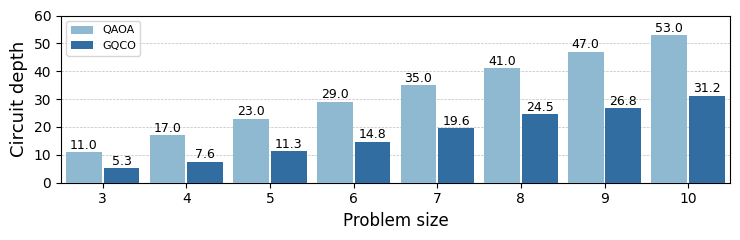

In [9]:
palette = {
    'Brute-force': sns.color_palette('Blues', 24)[10],
    'SA': sns.color_palette('Blues', 24)[14],
    'QAOA': sns.color_palette('Blues', 24)[10],
    # 'GQCO': sns.color_palette("viridis", 24)[3],
    'GQCO': sns.color_palette('Blues', 24)[18],
    'Random': sns.color_palette("Blues", 24)[1],
}


plt.figure(figsize=(7.5, 2.5))
ax = sns.barplot(
    data=df_forplot, 
    hue='solver',
    y='depth',
    x='size',
    hue_order=['QAOA', 'GQCO'],
    palette=palette,
    zorder=10,
    width=0.9,
    gap=0.05
)
plt.grid(axis='y', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=2)
plt.xlabel('Problem size', size=12)
plt.ylabel('Circuit depth', size=13)
plt.ylim([0, 60])
plt.legend(title=None, fontsize=8)
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f'{p.get_height() :.1f}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            fontsize=9, 
            color='black', 
            xytext=(0, 5), 
            textcoords='offset points',
            zorder=11,
            rotation=0
        )
plt.tight_layout()
plt.savefig('./outputs/svg/301_depth.svg')

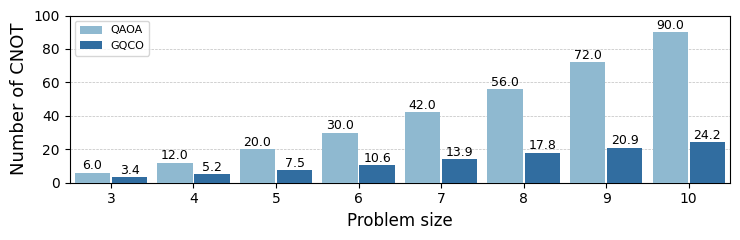

In [10]:
palette = {
    'Brute-force': sns.color_palette('Blues', 24)[10],
    'SA': sns.color_palette('Blues', 24)[14],
    'QAOA': sns.color_palette('Blues', 24)[10],
    # 'GQCO': sns.color_palette("viridis", 24)[3],
    'GQCO': sns.color_palette('Blues', 24)[18],
    'Random': sns.color_palette("Blues", 24)[1],
}


plt.figure(figsize=(7.5, 2.5))
ax = sns.barplot(
    data=df_forplot, 
    hue='solver',
    y='cnot',
    x='size',
    hue_order=['QAOA', 'GQCO'],
    palette=palette,
    zorder=10,
    width=0.9,
    gap=0.05
)
plt.grid(axis='y', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=2)
plt.xlabel('Problem size', size=12)
plt.ylabel('Number of CNOT', size=13)
plt.ylim([0, 100])
plt.legend(title=None, fontsize=8)
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f'{p.get_height() :.1f}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            fontsize=9, 
            color='black', 
            xytext=(0, 5), 
            textcoords='offset points',
            zorder=11,
            rotation=0
        )
plt.tight_layout()
plt.savefig('./outputs/svg/302_cnot.svg')

## Circuit Gram

In [136]:
size = 3

In [137]:
with open(f'../work/outputs/gqcoans_s42_t2.0_cl100_s{size}.pkl', 'rb') as f:
    dct = pickle.load(f)

In [138]:
from qiskit.quantum_info import Operator

599


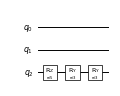

None

[0.25 0.   0.   0.   0.75 0.   0.   0.  ]
599


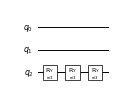

None

[7.70371978e-32 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
373


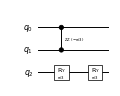

None

[0.25 0.   0.   0.   0.75 0.   0.   0.  ]
226


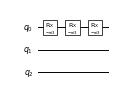

None

[7.70371978e-32 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
221


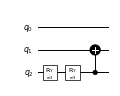

None

[0.25 0.   0.   0.   0.   0.   0.75 0.  ]


In [141]:

from collections import Counter

def find_frequent_subsequences_across_sequences(sequences, k):
    subsequences = []
    for sequence in sequences:
        subsequences.extend([tuple(sequence[i:i+k]) for i in range(len(sequence) - k + 1)])
    counts = Counter(subsequences)
    return counts#set(counts.items())

counts = find_frequent_subsequences_across_sequences(dct['tokens'], 3)


for m in range(5):
    seq, cnt = counts.most_common()[m]
    print(cnt)

    token = list(seq)
    
    while token and token[-1] == 0:
        token.pop()

    qc = taskobj.get_circuit(token, size)
    gate_matrix = Operator(qc.qc).data
    display(qc.draw())

    array = []
    for v in Statevector(qc.qc):
        array.append(v)
    vec = np.array(array)
    
    print(np.abs(vec)**2)

In [103]:
gate_matrix

array([[2.40370336e-16-1.38777878e-16j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, ...,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 2.40370336e-16+1.38777878e-16j,
        0.00000000e+00+0.00000000e+00j, ...,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        2.40370336e-16+1.38777878e-16j, ...,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j],
       ...,
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, ...,
        0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        2.40370336e-16-1.38777878e-16j],
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+0

In [86]:
counts.most_common()[0]

((301, 61, 61, 61, 931), 561)

In [82]:
def make_circuit(token):
    while token and token[-1] == 0:
        token.pop()

    qc = taskobj.get_circuit(token, size)
    # transpiled_qc = transpile(qc.qc.decompose(), optimization_level=1)

    display(qc.draw())
    # display(qc.draw(is_transpile=True))
    # print(transpiled_qc.depth())



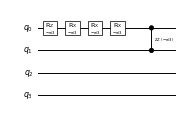

None

In [83]:
make_circuit([301, 61, 61, 61, 931])

In [66]:
dct['tokens']

[[301, 61, 61, 61, 931, 1313, 281, 1559, 1541, 1599],
 [283, 123, 123, 123, 361, 1580, 304, 968, 343, 1561],
 [301, 61, 61, 61, 931, 1313, 281, 1560, 1597, 1578],
 [283, 123, 123, 123, 931, 380, 552, 361, 779, 362],
 [283, 123, 123, 123, 361, 1580, 304, 968, 343, 1522],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1599, 1580],
 [283, 123, 123, 123, 931, 380, 968, 380, 361, 1599],
 [301, 61, 61, 61, 931, 1313, 281, 552, 931, 1540],
 [301, 61, 61, 61, 931, 1313, 281, 552, 552, 931],
 [301, 61, 61, 61, 931, 1313, 281, 552, 931, 1578],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1599, 1580],
 [283, 123, 123, 123, 361, 1541, 302, 362, 343, 1560],
 [301, 61, 61, 61, 931, 1313, 281, 1560, 1597, 1540],
 [301, 61, 61, 61, 931, 1313, 281, 1560, 1597, 1540],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1541, 1599],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1599, 1580],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1541, 1580],
 [301, 61, 61, 61, 931, 380, 951, 931, 968, 931],
 [301, 61, 61, 61, 931, 1313, 281, 55

In [53]:
adj = testdata[size][0]

In [54]:
qc = make_qaoa_circuit(adj, 1)

In [58]:
transpiled_qc = transpile(qc.decompose(), optimization_level=1)

transpiled_qc.depth()
# transpiled_qc.count_ops().get('cx', 0)

23

In [35]:
def make_circuit(token):
    while token and token[-1] == 0:
        token.pop()

    qc = taskobj.get_circuit(token, size)
    transpiled_qc = transpile(qc.qc.decompose(), optimization_level=1)

    # display(qc.draw())
    display(qc.draw(is_transpile=True))
    print(transpiled_qc.depth())

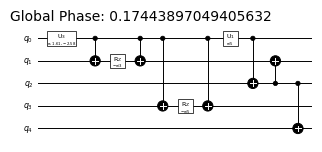

None

11


In [36]:
draw_circuit([301, 61, 61, 61, 931, 1313, 281, 1559, 1541, 1599])

In [22]:
dct['tokens']

[[301, 61, 61, 61, 931, 1313, 281, 1559, 1541, 1599],
 [283, 123, 123, 123, 361, 1580, 304, 968, 343, 1561],
 [301, 61, 61, 61, 931, 1313, 281, 1560, 1597, 1578],
 [283, 123, 123, 123, 931, 380, 552, 361, 779, 362],
 [283, 123, 123, 123, 361, 1580, 304, 968, 343, 1522],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1599, 1580],
 [283, 123, 123, 123, 931, 380, 968, 380, 361, 1599],
 [301, 61, 61, 61, 931, 1313, 281, 552, 931, 1540],
 [301, 61, 61, 61, 931, 1313, 281, 552, 552, 931],
 [301, 61, 61, 61, 931, 1313, 281, 552, 931, 1578],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1599, 1580],
 [283, 123, 123, 123, 361, 1541, 302, 362, 343, 1560],
 [301, 61, 61, 61, 931, 1313, 281, 1560, 1597, 1540],
 [301, 61, 61, 61, 931, 1313, 281, 1560, 1597, 1540],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1541, 1599],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1599, 1580],
 [301, 61, 61, 61, 931, 1313, 281, 1559, 1541, 1580],
 [301, 61, 61, 61, 931, 380, 951, 931, 968, 931],
 [301, 61, 61, 61, 931, 1313, 281, 55